# Equivilent Width

This notebook compares pseudo-equivilent widths (pW) between CMFGEN models and CSP spectroscopy. pW values are determine according to the prescription set forth in the CSP DR1 data release Folatelli et al. 2013. For each feature, "the pW is obtained by defining a straight 'continuum' level between two neighboring flux peaks and computing the integral of the spectrum flux relative to the continuum" (Folatelli 2013).


In [1]:
import sys
from pathlib import Path
import numpy as np
import sncosmo
from astropy.table import Table, join
from matplotlib import pyplot as plt
from sndata.csp import dr1, dr3
from specutils.analysis import equivalent_width
from specutils.fitting import fit_generic_continuum

sys.path.insert(0, '../')
from analysis import equivalent_width as ew
from analysis import models
from analysis import utils


In [2]:
models.register_sources(force=True)
dr1.download_module_data()
dr3.register_filters()

# Load models for different masses
m102 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.02))
m104 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.04))
m14 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.4))
m17 = sncosmo.Model(sncosmo.get_source('CMFGEN', version=1.7))

# Add an extinction component to each model
# The extinction component is zero until changed
model_list = [m102, m104, m14, m17]
for model in model_list:
    model.add_effect(sncosmo.F99Dust(), 'ext', 'rest')


## Identifying Features

We consider the same set of features considered in Folatelli et al. 2013.

In [3]:
# Features are stored as a dict, but we display them as a
# dictionary for easier mental parsing.
feature_table = Table(list(ew.features.values()))
feature_table ['feature_name'] = list(ew.features.keys())
feature_table


feature_id,lower_blue,lower_red,upper_blue,upper_red,feature_name
str17,int64,int64,int64,int64,str3
Ca ii H&K,3500,3900,3800,4100,pW1
Si ii λ4130,3900,4000,4000,4150,pW2
"Mg ii, Fe ii",3900,4450,4150,4700,pW3
"Fe ii, Si ii",4500,5050,4700,5550,pW4
"S ii λ5449, λ5622",5150,5500,5300,5700,pW5
Si ii λ5972,5550,5800,5700,6000,pW6
Si ii λ6355,5800,6200,6000,6600,pW7
Ca ii IR triplet,7500,8200,8000,8900,pW8


In [4]:
def plot_spectra(obs_dates, wavelength, flux, **kwargs):
    """Plot spectra
    
    Args:
        obs_dates  (list): A list of observed MJD dates for each spectra
        wavelength (list): A 2d list of wavelength values for each date
        flux       (list): A 2d list of flux values for each date
        Any other arguments for ``axis.plot``
    """
    
    fig, axis = plt.subplots(1, 1, figsize=(10, 10))    
    plot_data = zip(obs_dates, wavelength, flux)
    for i, (date, wave, flux) in enumerate(plot_data):
        axis.plot(wave, flux + i * 2e-15, label=str(date), **kwargs)
        axis.legend()
    
    return fig, axis


def plot_ew(obs_dates, wavelength, flux, feature_table, **kwargs):
    """
    
    Args:
        obs_dates      (list): A list of observed MJD dates for each spectra
        wavelength     (list): A 2d list of wavelength values for each date
        flux           (list): A 2d list of flux values for each date
        feature_table (Table): A table defining spectral features
        Any other arguments for ``axis.plot``
    """

    fig, axis = plot_spectra(obs_dates, wavelength, flux)

    for i, (time, wave, fluxx) in enumerate(zip(obs_dates, wavelength, flux)):
        for feature in ew.features.values():
            try:
                feat_start, feat_end = ew.get_feature_bounds(wave, fluxx, feature)

            except ew.UnobservedFeature:
                continue

            # Get observed wavelength and flux for each feature
            indices = (feat_start < wave) & (wave < feat_end)
            spectral_wave = wave[indices]
            spectral_flux = fluxx[indices]
            
            # Get continuum and plot
            cont_func = ew.fit_continuum_func(wave, fluxx, feat_start, feat_end)
            continuum_flux = cont_func(spectral_wave)
            axis.fill_between(
                spectral_wave,
                spectral_flux + i * 2e-15,
                continuum_flux + i * 2e-15, 
                color='tan', 
                alpha=.75)
            

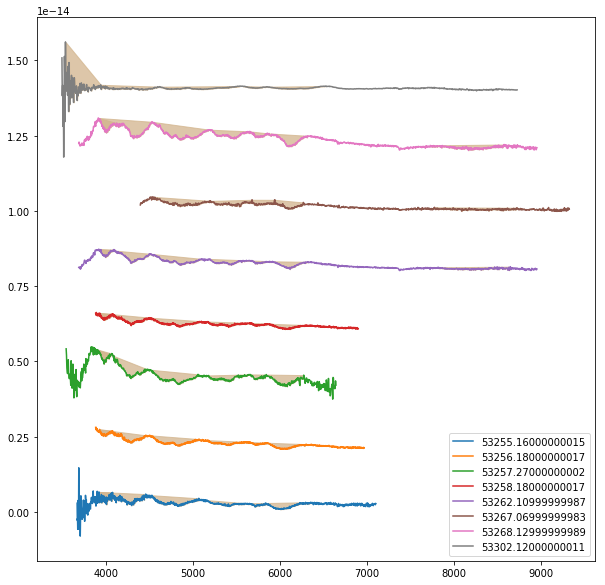

In [5]:
demo_id = '2004ef'
demo_data = dr1.get_data_for_id(demo_id)
obs_dates, wavelength, flux = utils.parse_spectra_table(demo_data)
plot_ew(obs_dates, wavelength, flux, ew.features)


## Comparing CMFGEN Against Observations

We read in a table of our pw results for each target/model. pw values are calculated both by fixing the feature boundaries to those determined by the observed spectrum and also by determining the feature boundaries for each observed/modeled spectrum individually.

In [6]:
results_dir = Path('../results')
fixed_width = Table.read(results_dir / 'equivalent_width/fixed_True.ecsv').to_pandas()
free_width = Table.read(results_dir / 'equivalent_width/fixed_True.ecsv').to_pandas()

fixed_width.set_index(['model', 'version', 'time'], inplace=True)
free_width.set_index(['model', 'version', 'time'], inplace=True)

fixed_width.head()


pW2  pW2_start    pW2_end         pW3  \
model    version time                                                    
OBSERVED NaN     53262.21  26.497922  3962.0978  4069.4701  304.262959   
CMFGEN   1.04    53262.21 -12.225114  3962.0978  4069.4701  433.736879   
         1.02    53262.21  -9.642062  3962.0978  4069.4701  414.281514   
         1.4     53262.21  -4.779322  3962.0978  4069.4701  369.654454   
         1.7     53262.21 -13.425655  3962.0978  4069.4701  453.428437   

                           pW3_start    pW3_end         pW4  pW4_start  \
model    version time                                                    
OBSERVED NaN     53262.21  3962.0978  4603.3489  378.149862  4603.3489   
CMFGEN   1.04    53262.21  3962.0978  4603.3489 -153.924666  4603.3489   
         1.02    53262.21  3962.0978  4603.3489 -134.901916  4603.3489   
         1.4     53262.21  3962.0978  4603.3489 -107.398136  4603.3489   
         1.7     53262.21  3962.0978  4603.3489 -221.867742  4603.3489   

                             pW4_end        pW5  ...         pW7  pW7_start  \
model    version time                            ...                          
OBSERVED NaN     53262.21  5501.1004  31.888133  ...  250.146269   5832.165   
CMFGEN   1.04    53262.21  5501.1004  51.599094  ...  228.743353   5832.165   
         1.02    53262.21  5501.1004  55.234374  ...  172.483141   5832.165   
         1.4     53262.21  5501.1004  49.741466  ...  140.880636   5832.165   
         1.7     53262.21  5501.1004  58.830764  ...  232.042516   5832.165   

                             pW7_end         pW8  pW8_start  pW8_end  obj_id  \
model    version time                                                          
OBSERVED NaN     53262.21  6547.9801  395.205445  7708.1972   8665.6  2004dt   
CMFGEN   1.04    53262.21  6547.9801 -121.494567  7708.1972   8665.6  2004dt   
         1.02    53262.21  6547.9801  292.058924  7708.1972   8665.6  2004dt   
         1.4     53262.21  6547.9801  321.063746  7708.1972   8665.6  2004dt   
         1.7     53262.21  6547.9801  139.633738  7708.1972   8665.6  2004dt   

                           pW1  pW1_start  pW1_end  
model    version time                               
OBSERVED NaN     53262.21  NaN        NaN      NaN  
CMFGEN   1.04    53262.21  NaN        NaN      NaN  
         1.02    53262.21  NaN        NaN      NaN  
         1.4     53262.21  NaN        NaN      NaN  
         1.7     53262.21  NaN        NaN      NaN  

[5 rows x 25 columns]

We plot the pw values at peak for feature 7 (Si II 6355) verses feature 6 (si II 5972). Observed values are taken from the CSP DR1 paper.

In [7]:
def plot_peak_pew(model_pew_table):
    """Plot peak pW7 vs peak pW7 for modeled and observed values
    
    Args:
        peak_pew_table (Table): A table of modeled pw values at Bmax
    """

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for axis, typing_system in zip(axes.flatten(), ('Type', 'Wst', 'Bst')):
        csp_type_table = dr1.load_table(1)['SN', typing_system]
        is_typed = ~csp_type_table[typing_system].mask
        csp_type_table = csp_type_table[is_typed]
        
        csp_pew = dr1.load_table(6)
        for subtype in set(csp_type_table[typing_system]):
            is_subtype = csp_type_table[typing_system] == subtype
            obj_ids = csp_type_table['SN'][is_subtype]
            plot_data = csp_pew[np.isin(csp_pew['SN'], obj_ids)]
            
            axis.scatter(plot_data['pW7'], plot_data['pW6'], label=subtype)
            axis.errorbar(plot_data['pW7'], plot_data['pW6'],
                          xerr=plot_data['e_pW7'], yerr=plot_data['e_pW6'], 
                          linestyle='', label=None)

        axis.scatter(model_pew_table['pW7'], model_pew_table['pW6'],
                     label='CMFGEN', color='brown')
        
        axis.legend()
        axis.set_xlabel(r'pW7 (Si II 6355) [$\AA$]')
        axis.set_ylim(0, 70)
        axis.set_xlim(40, 190)
        
    axes[0].set_ylabel(r'pW6 (Si II 5972) [$\AA$]')


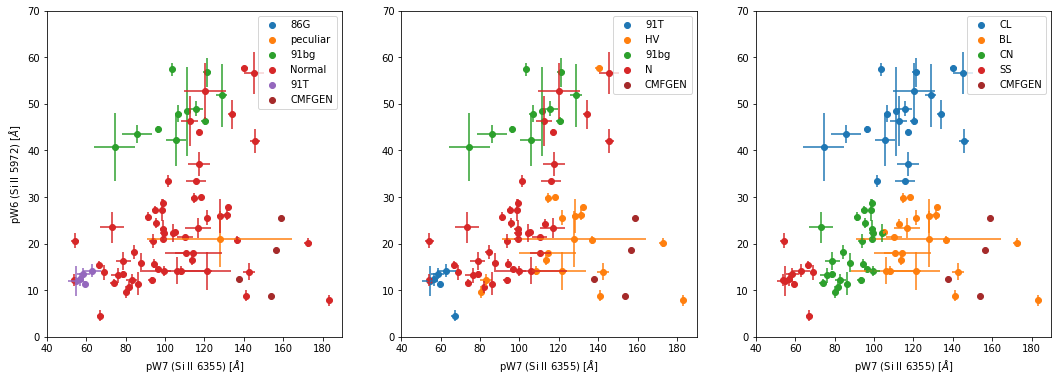

In [8]:
peak_pew_table = ew.tabulate_peak_model_pew(model_list)
plot_peak_pew(peak_pew_table)
